In [1]:

import matplotlib.pyplot as plt
import torch
import torchvision
from torchvision import transforms
from torch.utils import data
from d2l import torch as d2l
from IPython import display

batch_size=256
train_iter,test_iter=d2l.load_data_fashion_mnist(batch_size)
print(len(train_iter))

235


In [2]:
nums_inputs=784#展开每个图像，变成长度为784的向量
nums_outputs=10#网络输出维度=10

W=torch.normal(0,0.01,size=(nums_inputs,nums_outputs),dtype=torch.float32,requires_grad=True)
b=torch.zeros(nums_outputs,requires_grad=True)

In [3]:
def softmax(X):
    X_exp=torch.exp(X)
    partition=X_exp.sum(1,keepdim=True)
    return X_exp/partition

In [4]:
X=torch.normal(0,1,(2,5))
X_prob=softmax(X)
X,X_prob,X_prob.sum(1,keepdim=True)

(tensor([[-2.3448,  2.3969,  0.1807, -1.4688, -1.3829],
         [ 0.1939, -1.4819,  1.1418,  0.1975,  1.6751]]),
 tensor([[0.0075, 0.8609, 0.0939, 0.0180, 0.0197],
         [0.1091, 0.0204, 0.2814, 0.1095, 0.4797]]),
 tensor([[1.],
         [1.]]))

In [5]:
def net(X):
    return softmax(torch.matmul(X.reshape((-1,W.shape[0])),W)+b) #reshape成一个2D的，shape[0]=784
#256*784的矩阵

In [6]:
y=torch.tensor([0,2])
y_hat=torch.tensor([[0.1,0.3,0.6],[0.3,0.2,0.5]])
y_hat[[0,1],y]#这个意思是从y[0]里拿0号元素，从y[1]里拿2号元素


tensor([0.1000, 0.5000])

In [7]:
def cross_entropy(y_hat,y):
    return -torch.log(y_hat[range(len(y_hat)),y])

cross_entropy(y_hat,y)

tensor([2.3026, 0.6931])

In [8]:
def accuracy(y_hat,y):
    if len(y_hat.shape)>1 and y_hat.shape[1]>1:
            y_hat=y_hat.argmax(axis=1)#找到最大的索引
    #print(y_hat)
    cmp=y_hat.type(y.dtype) ==y
    #print(cmp)
    return float(cmp.type(y.dtype).sum())/len(y)

accuracy(y_hat,y)

0.5

In [9]:
def evaluate_accuracy(net,data_iter):
    if isinstance(net,torch.nn.Module):
        net.eval()
    metric = Accumulator(2) #正确预测数，预测总数
    for X,y in data_iter:
        metric.add(accuracy(net(X),y),y.numel())
    return metric[0]/metric[1]

In [10]:
class Accumulator:
    def __init__(self,n):
        self.data=[0.0]*n
    def add(self,*args):
        self.data=[a+float(b) for a,b in zip(self.data,args)]
    def reset(self):
        self.data=[0.0]*len(self.data)
    def __getitem__(self,dix):
        return self.data[dix]
evaluate_accuracy(net,test_iter)

0.000348828125

In [11]:
class Animator:  
    """在动画中绘制数据。"""
    def __init__(self, xlabel=None, ylabel=None, legend=None, xlim=None,
                 ylim=None, xscale='linear', yscale='linear',
                 fmts=('-', 'm--', 'g-.', 'r:'), nrows=1, ncols=1,
                 figsize=(3.5, 2.5)):
        if legend is None:
            legend = []
        d2l.use_svg_display()
        self.fig, self.axes = d2l.plt.subplots(nrows, ncols, figsize=figsize)
        if nrows * ncols == 1:
            self.axes = [self.axes,]
        self.config_axes = lambda: d2l.set_axes(self.axes[
            0], xlabel, ylabel, xlim, ylim, xscale, yscale, legend)
        self.X, self.Y, self.fmts = None, None, fmts

    def add(self, x, y):
        if not hasattr(y, "__len__"):
            y = [y]
        n = len(y)
        if not hasattr(x, "__len__"):
            x = [x] * n
        if not self.X:
            self.X = [[] for _ in range(n)]
        if not self.Y:
            self.Y = [[] for _ in range(n)]
        for i, (a, b) in enumerate(zip(x, y)):
            if a is not None and b is not None:
                self.X[i].append(a)
                self.Y[i].append(b)
        self.axes[0].cla()
        for x, y, fmt in zip(self.X, self.Y, self.fmts):
            self.axes[0].plot(x, y, fmt)
        self.config_axes()
        display.display(self.fig)
        display.clear_output(wait=True)

In [12]:
lr=0.01

def updater(batch_size):
    return d2l.sgd([W,b],lr,batch_size)
    

In [13]:
def train_epoch_ch3(net,train_iter,loss,updater):
    if isinstance(net,torch.nn.Module):
        net.train()
    metric=Accumulator(3)
    for X,y in train_iter:
        y_hat=net(X)
        l=loss(y_hat,y)
        if isinstance(updater,torch.optim.Optimizer):
            updater.zero_grad()
            l.backward()
            updater.step()
            metric.add(
                float(1)*len(y),accuracy(y_hat,y),y.size().numel()
            )
        else:
            l.sum().backward()#
            updater(X.shape[0])#梯度的大小
            metric.add(float(l.sum()),accuracy(y_hat,y),y.numel())
    return metric[0]/metric[2],metric[1]/metric[2]

In [14]:
def train_ch3(net,train_iter,test_iter,loss,num_epoches,updater):
    for epoch in range(num_epoches):
        train_metrics=train_epoch_ch3(net,train_iter,loss,updater)
        test_acc=evaluate_accuracy(net,test_iter)
    train_loss,train_acc=train_metrics

In [15]:
num_epochs = 10
train_ch3(net, train_iter, test_iter, cross_entropy, num_epochs, updater)

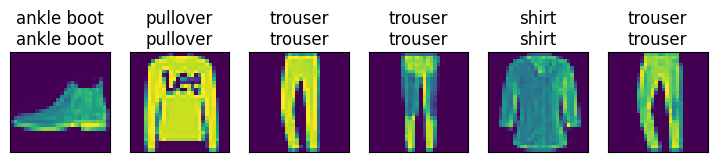

In [16]:
def predict_ch3(net,test_iter,n=6):
    for X,y in test_iter:
        break
    trues=d2l.get_fashion_mnist_labels(y)
    preds=d2l.get_fashion_mnist_labels(net(X).argmax(axis=1))
    titles=[true+'\n'+pred for true,pred in zip(trues,preds)]
    d2l.show_images(X[0:n].reshape((n,28,28)),1,n,titles=titles[0:n])
predict_ch3(net,test_iter)